# Detecting Sentiment and Potential Bias in Amazon Reviews

## Introduction

Our team recognizes that online product reviews are a rich source of public sentiment. However, the subjective nature of reviews can introduce bias. This project for our NLP class tries to investigate sentiment classification using NLP, with an interest in identifying patterns that may suggest some bias.

We are using the Amazon Fine Food Reviews dataset to explore 2 different approaches!
- TF-IDF + Logistic Regression baseline
- A transformer-based model (BERT)

Our goals are to implement models for sentiment detections and to analyze any potential misclassifications. Also, we want to examine indicators of potential review bias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk

In [2]:
df = pd.read_csv('./Reviews.csv')
print(df.shape)
df = df.head(500) #reducing to 500 rows for faster processing
print(df.shape)

(1000, 10)
(500, 10)


In [3]:
df.head() 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,227133,B000V4PW6M,A1RRHET1QIP1YK,Daniel Hill,0,0,5,1237161600,banana carmels,Something different for a change of pace. Nice...
1,212201,B000CNB4LE,A2YKLEW942F1UB,Camrea,1,1,5,1338249600,"Price jump on-line... can't find in stores,......",I love this drink! Tastes just like Yoohoo. Sa...
2,447125,B0002PCET8,A3P8ZINJYTAJP5,Aaron,0,0,5,1331596800,Love It!!!!!!!!!!!!!!!!!!!!,This soda is AMAZING!!!!! you have got to get ...
3,27305,B000LBGBP6,AQHX3MG6JY68,"Dee Burns ""dee""",2,2,5,1219968000,Chocolate - goodness - WOW,I can't stop eating these - so decadent <a hre...
4,248644,B004CZURWK,A1HD6Y4UDSYMC5,Mindy,0,0,5,1347840000,very pleased,Our Papillion is a very picky eater. She love...


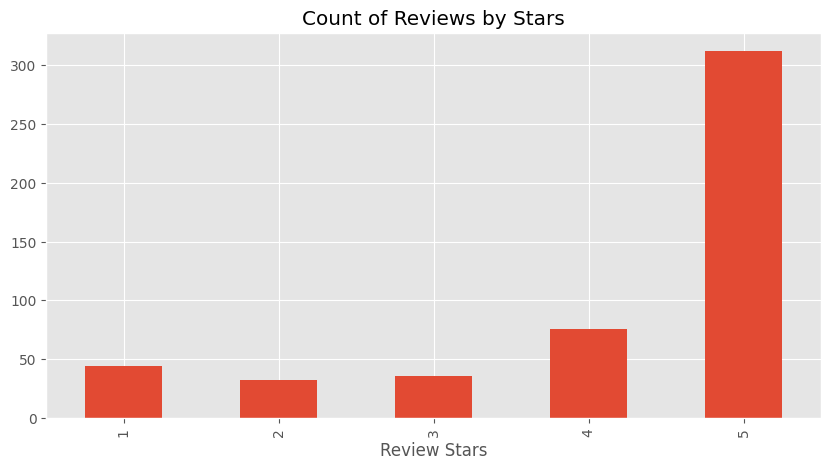

In [4]:
ax = df['Score'].value_counts().sort_index().plot(kind = "bar", 
                                             title = "Count of Reviews by Stars", 
                                             figsize=(10, 5))
ax.set_xlabel("Review Stars")
plt.show()

In [5]:
example = df['Text'][50]
print(example)

So glad to find these. My daughter is doctoral student with heavy schedule and celiac--these are so perfect for her to grab as a high quality snack. She likes the other two flavors (vanilla and chocolate also). So wonderful that they are gluten free. Not too sweet. Glad I 'pre-ordered' as this flavor seems perpetually sold out. Amazon makes it so easy to send little treats like this to my daughter who is several states away.


In [6]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['So', 'glad', 'to', 'find', 'these', '.', 'My', 'daughter', 'is', 'doctoral']

In [7]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('So', 'RB'),
 ('glad', 'JJ'),
 ('to', 'TO'),
 ('find', 'VB'),
 ('these', 'DT'),
 ('.', '.'),
 ('My', 'PRP$'),
 ('daughter', 'NN'),
 ('is', 'VBZ'),
 ('doctoral', 'JJ')]

In [8]:
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\farza\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
sia .polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [10]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [11]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [12]:
# VADER results on example
print(example)
sia.polarity_scores(example)

So glad to find these. My daughter is doctoral student with heavy schedule and celiac--these are so perfect for her to grab as a high quality snack. She likes the other two flavors (vanilla and chocolate also). So wonderful that they are gluten free. Not too sweet. Glad I 'pre-ordered' as this flavor seems perpetually sold out. Amazon makes it so easy to send little treats like this to my daughter who is several states away.


{'neg': 0.052, 'neu': 0.675, 'pos': 0.272, 'compound': 0.9675}

In [13]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.00187683, 'roberta_neu': 0.008822961, 'roberta_pos': 0.98930025}


In [14]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [15]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_results = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_results.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_results = polarity_scores_roberta(text)

        both = {**vader_result_rename, **roberta_results}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id149020
Broke for id184619
Broke for id159236


In [16]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index': 'Id'})
results_df = results_df.merge(df, how = 'left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,227133,0.000,0.653,0.347,0.7845,0.002093,0.022349,0.975558,B000V4PW6M,A1RRHET1QIP1YK,Daniel Hill,0,0,5,1237161600,banana carmels,Something different for a change of pace. Nice...
1,212201,0.032,0.814,0.154,0.8007,0.051834,0.090158,0.858008,B000CNB4LE,A2YKLEW942F1UB,Camrea,1,1,5,1338249600,"Price jump on-line... can't find in stores,......",I love this drink! Tastes just like Yoohoo. Sa...
2,447125,0.000,0.819,0.181,0.8507,0.002400,0.005681,0.991919,B0002PCET8,A3P8ZINJYTAJP5,Aaron,0,0,5,1331596800,Love It!!!!!!!!!!!!!!!!!!!!,This soda is AMAZING!!!!! you have got to get ...
3,27305,0.000,0.739,0.261,0.5556,0.010510,0.039597,0.949893,B000LBGBP6,AQHX3MG6JY68,"Dee Burns ""dee""",2,2,5,1219968000,Chocolate - goodness - WOW,I can't stop eating these - so decadent <a hre...
4,248644,0.000,0.689,0.311,0.8707,0.003571,0.024032,0.972397,B004CZURWK,A1HD6Y4UDSYMC5,Mindy,0,0,5,1347840000,very pleased,Our Papillion is a very picky eater. She love...


In [17]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

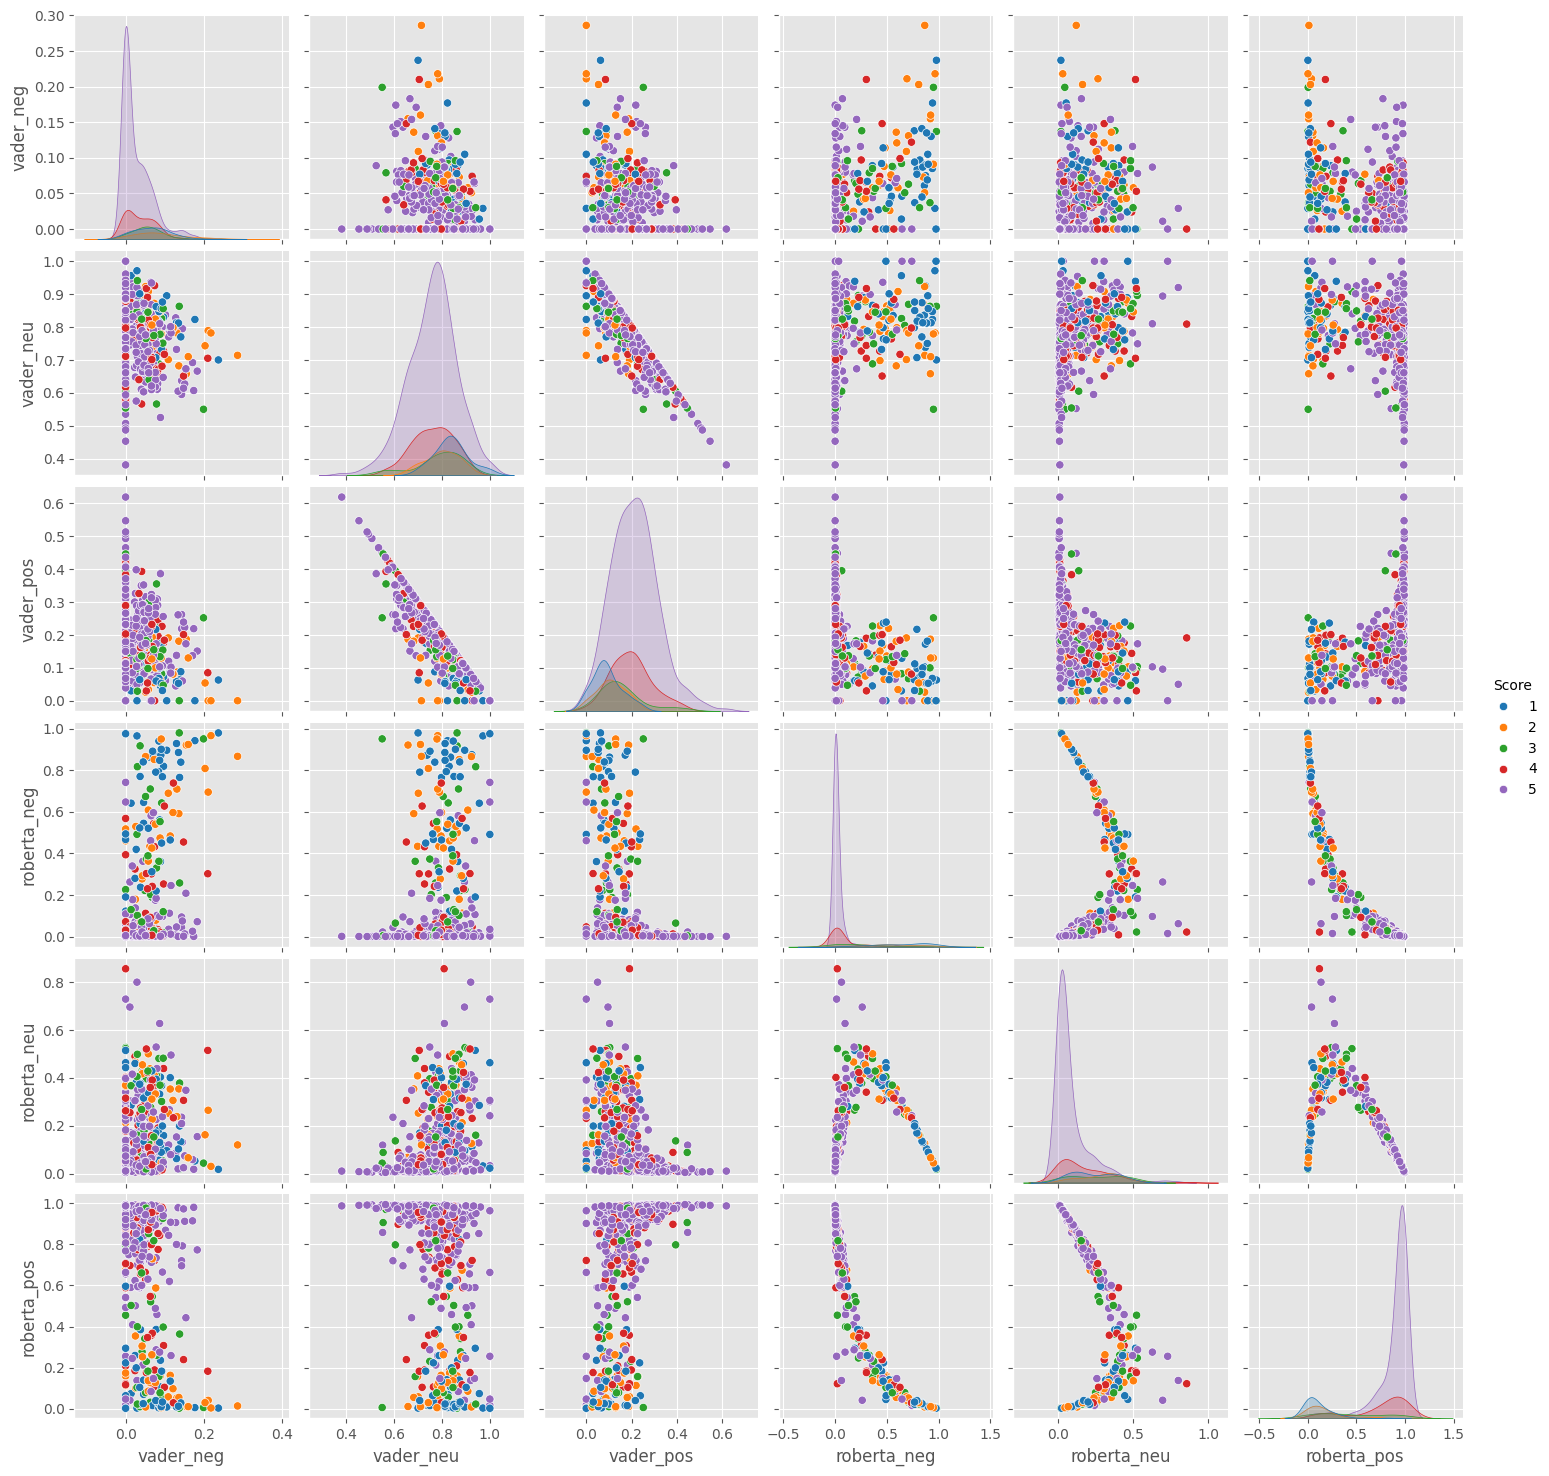

In [18]:
sns.pairplot(data=results_df, 
             vars= ['vader_neg', 'vader_neu', 'vader_pos',
              'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue = 'Score',
            palette = 'tab10')
plt.show()

In [19]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending = False)['Text'].values[0]

"I've been giving my daughter Gerber fruits, veggies, and meat as everyday-meals since she was 6 months old, thinking that she's got enough vitamins and prebiotics. However, she developed digestive problem and chronic constipation; she almost stopped gaining weight since she was 9 months old. I took her to GI and she told me that those packed fruits are all cooked! And there are additives to keep them fresh for long period of time! I started to puree fruits and veggies using Vitamix, and only use Gerber fruits&veggies when we are out and about. Now, after half a year of probiotics and wholesome food, she's slowly getting better and opens her mouth to food."

In [20]:
results_df.query('Score == 1').sort_values('vader_pos', ascending = False)['Text'].values[0]

'The ingredients clearly say "evaporated cane juice".  That is sugar.  Amazon needs to change the description.'

In [21]:
# negative sentiment 5-Star view

In [22]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

"My title says it all. Plus, the price per cup has not been equaled anywhere that I've checked."

In [23]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'This is an excellent "everything but the kitchen sink" blend.  It\'s my favorite tea.  High quality product and individual foil packaging to retain it.  Pity it was given such an idiotic name.'

In [24]:
from transformers import pipeline
sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [25]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [26]:
######################################################################################3

In [27]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding = 'latin-1', header = None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
# to reduce to 500 rows for faster processing
df = df.head(500) 
print(df.shape)

(500, 6)


In [28]:
df.head()


,target,id,date,flag,user,text
0,0,1,2,3,4,5
1,4,2061966166,Sat Jun 06 22:01:12 PDT 2009,NO_QUERY,jhaggard1,@HeatherNAz I like to wait for the guest to sh...
2,0,2014932419,Wed Jun 03 03:09:48 PDT 2009,NO_QUERY,finefrancie,"@betweenthenotes and poor me, i always have to..."
3,4,1558854458,Sun Apr 19 09:35:13 PDT 2009,NO_QUERY,LauraSauruss,@glorytorres no. I was simply pointing out tha...
4,4,2013657029,Tue Jun 02 23:13:34 PDT 2009,NO_QUERY,fff_cloud7,"High, waiting for my food to come out of mcd's..."


In [29]:
#first 10 tweets
for i, tweet in enumerate(df['text'].head(10)):
    print(f"{i+1}: {tweet}")

1: 5
2: @HeatherNAz I like to wait for the guest to show up and then I hand them a mop. Then I go see a movie 
3: @betweenthenotes and poor me, i always have to find new things that hes not getting bored  not easy really
4: @glorytorres no. I was simply pointing out that no, it's not what I think! @ashleeluv it ain't no squabble, ho! 
5: High, waiting for my food to come out of mcd's. Got an 88 on test 
6: @bmichalk turns out he was acting asleep... That little tricker! 
7: excited to see @alexandrabrandt in a couple days. but now its time to put on sigur ros and PASS OUT considering i wake up at 5am for work 
8: Today is a good day. 
9: @fittorrent How are you feeling today? Besides being starved for food for the past 10 hrs  good to see you back tweeting.
10: Thinks tigger has been in a fight.. Fur has been ripped off his tail and it looks swollen  ..  http://yfrog.com/5fcmkj


In [30]:
analyze = SentimentIntensityAnalyzer()

In [31]:
#testing the vader sentiment analysis
print(analyze.polarity_scores('I am so happy'))
print(analyze.polarity_scores('I am so sad'))

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}
{'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}


In [32]:
def polarity_scores_vader(text):
    scores = analyze.polarity_scores(text)
    scores_dict = {
        'vader_neg': scores['neg'],
        'vader_neu': scores['neu'],
        'vader_pos': scores['pos'],
        'vader_compound' : scores['compound']
    }
    return scores_dict

In [33]:
#running vader polarity scores on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try: 
        text = row['text']
        myid = row['id']
    #     direct way of doing it: res[myid] = analyze.polarity_scores(text)
        vader_results = polarity_scores_vader(text)
        res[myid] = vader_results
    except RunTimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [34]:
#creating a dataframe from the res dictionary
vaders_df = pd.DataFrame(res).T
vaders_df = vaders_df.reset_index().rename(columns={'index':'id'})
vaders_df = vaders_df.merge(df, how = 'left')

In [35]:
print(vaders_df.head())

           id  vader_neg  vader_neu  vader_pos  vader_compound  target  \
0           1      0.000      0.000      0.000          0.0000       0   
1  2061966166      0.000      0.749      0.251          0.6908       4   
2  2014932419      0.247      0.672      0.081         -0.5707       0   
3  1558854458      0.324      0.676      0.000         -0.7339       4   
4  2013657029      0.000      1.000      0.000          0.0000       4   

                           date      flag          user  \
0                             2         3             4   
1  Sat Jun 06 22:01:12 PDT 2009  NO_QUERY     jhaggard1   
2  Wed Jun 03 03:09:48 PDT 2009  NO_QUERY   finefrancie   
3  Sun Apr 19 09:35:13 PDT 2009  NO_QUERY  LauraSauruss   
4  Tue Jun 02 23:13:34 PDT 2009  NO_QUERY    fff_cloud7   

                                                text  
0                                                  5  
1  @HeatherNAz I like to wait for the guest to sh...  
2  @betweenthenotes and poor me, i 

In [36]:
#to get the vader_sentiment column
vaders_df['vader_sentiment'] = vaders_df['vader_compound'].apply(lambda c: 'pos' if c >= 0 else 'neg')

In [37]:
print(vaders_df.columns)
print(vaders_df[['id', 'vader_compound', 'vader_sentiment']].head())
print(vaders_df['vader_compound'].isnull().sum())

Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'target',
       'date', 'flag', 'user', 'text', 'vader_sentiment'],
      dtype='object')
           id  vader_compound vader_sentiment
0           1          0.0000             pos
1  2061966166          0.6908             pos
2  2014932419         -0.5707             neg
3  1558854458         -0.7339             neg
4  2013657029          0.0000             pos
0


C:\Users\farza\AppData\Local\Temp\ipykernel_26496\141843628.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='vader_sentiment', data=vaders_df, palette='viridis')


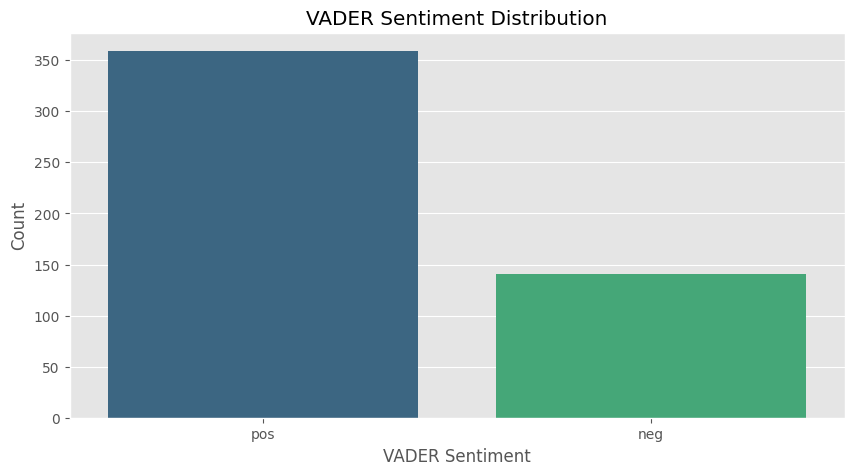

In [38]:
#visualization of the sentiments using vader
plt.figure(figsize=(10, 5))
sns.countplot(x='vader_sentiment', data=vaders_df, palette='viridis')
plt.title('VADER Sentiment Distribution')
plt.xlabel('VADER Sentiment')
plt.ylabel('Count')
plt.show()

In [39]:
#roberta analysis
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [40]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [41]:
#running the roberta model 
def polarity_scores_roberta(text):
    # make the text to tokens
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text) #**encoded_text unpacks the dictionary
    scores = output[0][0].detach().numpy()
    #softmax converts logits into probabilities that sum to 1
    #providing the models confidence in each class (pos.neg,neu)
    scores = softmax(scores) 
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [42]:
#running it on the entire dataset
result = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['text']
        myid = row['id']
        vader_results = analyze.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_results.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_results = polarity_scores_roberta(text)
#         result[myid] = roberta_results
        both = {**vader_result_rename, **roberta_results}
        result[myid] = both
    except RunTimeError:
        print(f'Broke for id{myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [43]:
results_df = pd.DataFrame(result).T
results_df = results_df.reset_index().rename(columns = {'index' : 'id'})
results_df = results_df.merge(df, how = 'left')

In [44]:
print(results_df.head())

           id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0           1      0.000      0.000      0.000          0.0000     0.222411   
1  2061966166      0.000      0.749      0.251          0.6908     0.054050   
2  2014932419      0.247      0.672      0.081         -0.5707     0.703816   
3  1558854458      0.324      0.676      0.000         -0.7339     0.332245   
4  2013657029      0.000      1.000      0.000          0.0000     0.107173   

   roberta_neu  roberta_pos  target                          date      flag  \
0     0.501255     0.276334       0                             2         3   
1     0.617997     0.327952       4  Sat Jun 06 22:01:12 PDT 2009  NO_QUERY   
2     0.245702     0.050482       0  Wed Jun 03 03:09:48 PDT 2009  NO_QUERY   
3     0.570456     0.097299       4  Sun Apr 19 09:35:13 PDT 2009  NO_QUERY   
4     0.619515     0.273311       4  Tue Jun 02 23:13:34 PDT 2009  NO_QUERY   

           user                                   

In [45]:
#create a new column for roberta sentiment based on the highest score
results_df['roberta_sentiment'] = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']].idxmax(axis=1)
results_df['roberta_sentiment'] = results_df['roberta_sentiment'].map({
    'roberta_neg': 'negative',
    'roberta_neu': 'neutral',
    'roberta_pos': 'positive'
})

In [46]:
#showing vader sentiment in the new dictionary
results_df['vader_sentiment'] = results_df['vader_compound'].apply(lambda c: 'pos' if c >= 0 else 'neg')

C:\Users\farza\AppData\Local\Temp\ipykernel_26496\1213993125.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'roberta_sentiment', data=results_df, palette = 'viridis')


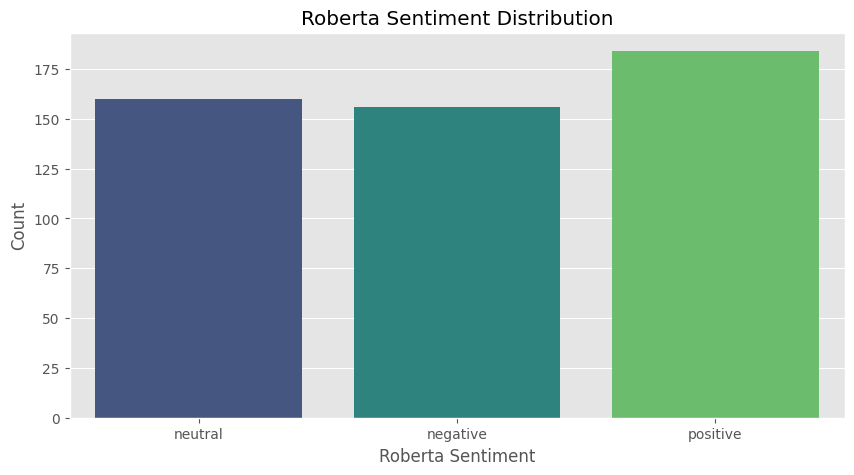

In [47]:
#visualizing the roberta sentiment distribution 
plt.figure(figsize = (10,5))
sns.countplot(x = 'roberta_sentiment', data=results_df, palette = 'viridis')
plt.title('Roberta Sentiment Distribution')
plt.xlabel('Roberta Sentiment')
plt.ylabel('Count')
plt.show()

C:\Users\farza\AppData\Local\Temp\ipykernel_26496\607411220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x='vader_sentiment', data=results_df, palette='viridis')
C:\Users\farza\AppData\Local\Temp\ipykernel_26496\607411220.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], x='roberta_sentiment', data=results_df, palette='viridis')


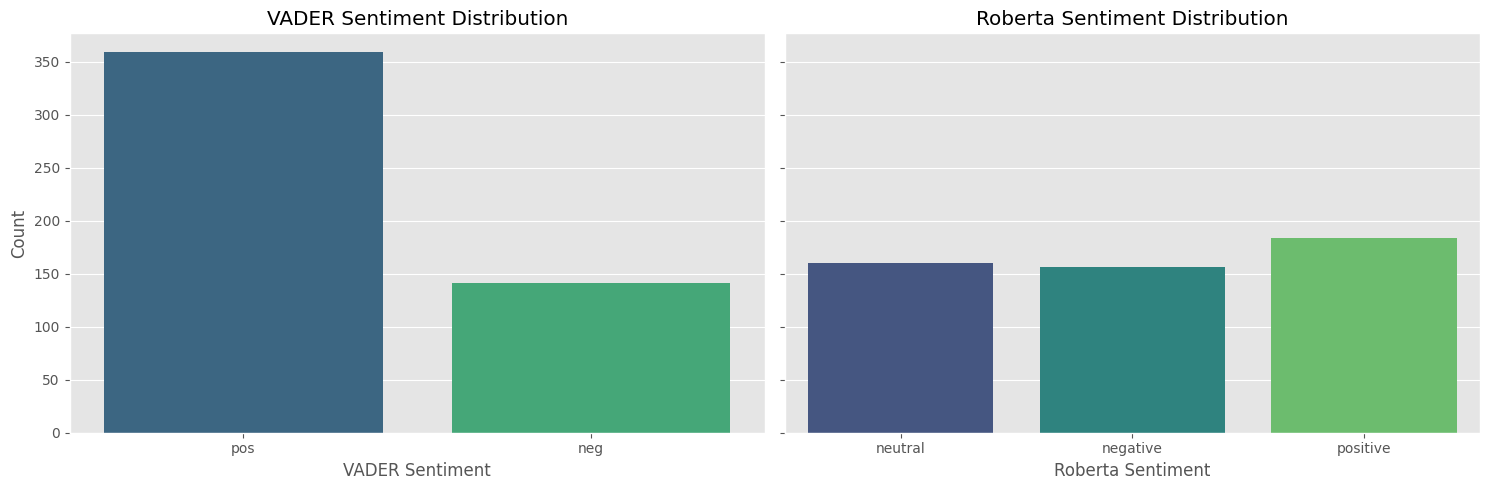

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.countplot(ax=axes[0], x='vader_sentiment', data=results_df, palette='viridis')
axes[0].set_title('VADER Sentiment Distribution')
axes[0].set_xlabel('VADER Sentiment')
axes[0].set_ylabel('Count')
sns.countplot(ax=axes[1], x='roberta_sentiment', data=results_df, palette='viridis')
axes[1].set_title('Roberta Sentiment Distribution')
axes[1].set_xlabel('Roberta Sentiment')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [49]:
print(df.columns)


Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')


## Text Preprocessing

For our next step, we will try to clean and prepare the review texts for model training. 

Precisely, we will remove punctuation and stop word, tokenize, and label encode the sentiment classes as part of pre-processing.


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

def preprocess(text):
    tokens = text.lower().split()
    tokens = [word.strip(string.punctuation) for word in tokens if word.lower() not in stopwords.words('english')]
    return " ".join(tokens)

df['processed_text'] = df['text'].astype(str).apply(preprocess)
df['label'] = df['target'].apply(lambda x: 1 if x > 3 else 0)  # Binary sentiment

X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\farza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


As part of our baseline model, we will build a simple text classifier using TF-IDF features and a Logistic Regression model. 

In [51]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train_vec, y_train)
y_pred_lr = lr_model.predict(X_test_vec)

print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.63      0.58      0.61        53
           1       0.57      0.62      0.59        47

    accuracy                           0.60       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.60      0.60      0.60       100



In [53]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import numpy as np

# Recreate label_id column (binary: 0 or 1)
label_enc = LabelEncoder()
df['label_id'] = label_enc.fit_transform(df['label'])  # Assumes 'label' is present and already binary

# Load RoBERTa sentiment model and tokenizer
roberta_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)
model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name)

# Set up pipeline
roberta_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Run predictions on a sample of test data
sample_texts = df['text'].tolist()[:100]  # Subsample for speed
roberta_preds = []

for text in tqdm(sample_texts):
    result = roberta_pipeline(text)[0]['label']
    roberta_preds.append(result.lower())

# Map RoBERTa sentiment labels to binary: pos → 1, neg → 0
roberta_binary = [1 if label == 'positive' else 0 for label in roberta_preds]

# Ground truth for comparison
true_labels = df['label_id'].tolist()[:100]

# Evaluation
print("RoBERTa (Zero-Shot) Classification Report:")
print(classification_report(true_labels, roberta_binary))
print("RoBERTa Accuracy:", accuracy_score(true_labels, roberta_binary))


Device set to use cpu
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.31it/s]

RoBERTa (Zero-Shot) Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        57
           1       0.00      0.00      0.00        43

    accuracy                           0.57       100
   macro avg       0.28      0.50      0.36       100
weighted avg       0.32      0.57      0.41       100

RoBERTa Accuracy: 0.57



C:\Users\farza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\farza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\farza\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
nltk.download('vader_lexicon')

# Split data
X = df['processed_text']
y = df['label_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF + Logistic Regression
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)
acc_lr = accuracy_score(y_test, y_pred_lr)

# VADER
sid = SentimentIntensityAnalyzer()
vader_preds = []
for sentence in X_test:
    score = sid.polarity_scores(sentence)['compound']
    vader_preds.append(1 if score >= 0 else 0)
acc_vader = accuracy_score(y_test, vader_preds)

# Print Benchmark Summary
print("Benchmark Summary:")
print(f"TF-IDF + Logistic Regression Accuracy: {acc_lr:.4f}")
print(f"VADER Accuracy: {acc_vader:.4f}")
print("RoBERTa Accuracy: See previous cell output (approx. on same 100 samples)")


Benchmark Summary:
TF-IDF + Logistic Regression Accuracy: 0.6000
VADER Accuracy: 0.6000
RoBERTa Accuracy: See previous cell output (approx. on same 100 samples)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\farza\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
import evaluate
import numpy as np

# Re-encode labels (binary classification: 0 or 1)
label_enc = LabelEncoder()
df['label_id'] = label_enc.fit_transform(df['label'])  # assumes 'label' is binary already

# Prepare dataset for Hugging Face Trainer
df_hf = df[['text', 'label_id']].rename(columns={'label_id': 'labels'})
dataset = Dataset.from_pandas(df_hf)
dataset = dataset.train_test_split(test_size=0.2)

# Tokenizer and Model
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Tokenize
def tokenize(example):
    return tokenizer(example['text'], truncation=True, padding='max_length')

tokenized_dataset = dataset.map(tokenize, batched=True)

# Metrics
accuracy = evaluate.load("accuracy")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy.compute(predictions=preds, references=p.label_ids)

# Training arguments
training_args = TrainingArguments(
    output_dir="./roberta_results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./roberta_logs',
    logging_steps=10,
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

# Fine-tune!
trainer.train()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\farza\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\farza\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
preds = trainer.predict(tokenized_dataset["test"])
from sklearn.metrics import classification_report, accuracy_score

y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("RoBERTa (Fine-tuned) Classification Report:")
print(classification_report(y_true, y_pred))
print("RoBERTa Accuracy:", accuracy_score(y_true, y_pred))


In [57]:
from transformers import TrainingArguments
help(TrainingArguments)


Help on class TrainingArguments in module transformers.training_args:

class TrainingArguments(builtins.object)
 |  TrainingArguments(output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.Sch